# Cal-CRAI Index: Climate Domain

**Order of operations**:
- Metric handling
   - Retrieve data
   - Min-max standardization
   - Set vulnerability orientation (pos for vulnerable, neg for resilience)
- Calculate indicators
   - Min-max standardization
- Calculate domain score
- Visualizations

Note: Functions and figures within this notebook are in development

In [1]:
import pandas as pd
import os
import sys
import warnings

# suppress pandas purely educational warnings
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

sys.path.append(os.path.expanduser('../../'))
from scripts.utils.file_helpers import pull_csv_from_directory, upload_csv_aws
from scripts.utils.write_metadata import append_metadata
from scripts.utils.index_plot import plot_domain, plot_region_domain
from scripts.utils.calculate_index import (handle_outliers, min_max_standardize, process_domain_csv_files, 
                                        compute_averaged_indicators, compute_summed_indicators, indicator_dicts, 
                                        add_census_tracts, domain_summary_stats, compute_summed_climate_indicators)

## Step 1: Metric level
### 1a) Retrieve metric files and process

In [2]:
# set-up
bucket_name = 'ca-climate-index'
aws_dir = '3_fair_data/index_data/'

pull_csv_from_directory(bucket_name, aws_dir, output_folder='aws_csvs', search_zipped=False, print_name=False)

Metric data retrieved from 3_fair_data/index_data/.


In [3]:
# domain-specific
domain_prefix = 'climate_'
input_folder = r'aws_csvs'
output_folder = domain_prefix + "folder"
meta_csv = r'../utils/calcrai_metrics.csv'
merged_output_file = f'concatenate_{domain_prefix}metrics.csv'

metric_vulnerable_resilient_dict = process_domain_csv_files(domain_prefix, input_folder, output_folder, meta_csv, merged_output_file)

Processed and saved 33 CSV files within climate_domain.

Metric resilience/vulnerable dictionary created and called: metric_vulnerable_resilient_dict

All entries within the island tract (6075980401) are NaN.

Number of infinite entries in the DataFrame: 0
Replacing infinite entries (if any) with NaN
Number of infinite entries in the DataFrame after replacement: 0

File processing complete, dataframe will now be saved as a .csv
Processed CSV saved as concatenate_climate_metrics.csv


### Now, take a look at the merged singluar csv file

In [4]:
# read-in and view processed data
pd.set_option('display.max_columns', None)
processed_climate_df = pd.read_csv(merged_output_file)
processed_climate_df

,GEOID,median_flood_warning_days,hospitals_count_diff,mean_change_annual_heat_days,average_annual_fatalities_wildfire,mean_change_cold_days,change_ffwi_days,police_stations_count_diff,drought_crop_loss_acres,surface_runoff,mean_change_annual_warm_nights,avg_flood_insurance_payout_per_claim,heat_crop_loss_indemnity_amount,estimated_flood_crop_loss_cost,drought_crop_loss_indemnity_amount,total_flood_fatalities,floodplain_percentage,avg_age_adjust_heat_hospitalizations_per_10000,precip_99percentile,drought_coverage_percentage,percent_weeks_drought,burn_area_m2,building_exposed_slr_count,heat_crop_loss_acres,median_red_flag_warning_days,rcp_4.5__50th_percent_change,fire_stations_count_diff,schools_count_diff,average_damaged_destroyed_structures_wildfire,slr_vulnerable_wastewater_treatment_count,slr_vulnerable_building_content_cost,slr_vulnerability_delta_percentage_change,median_heat_warning_days,change_in_drought_years
0,6085504321,2.0,0.0,3.383333,0.0,-3.550000,-0.183333,0.0,NaN,1.689066,11.541667,NaN,221115.456000,5000.0,NaN,2.0,22.04,61.8125,1.844490,35.687226,0.584854,NaN,1426.0,112.933200,1.5,-4.854369,1.0,2.0,13.0,3.0,590746.0,NaN,1.0,6.75
1,6085504410,2.0,0.0,3.383333,0.0,-3.550000,-0.183333,0.0,NaN,1.689066,11.541667,NaN,221115.456000,5000.0,NaN,2.0,11.04,61.8125,1.844490,35.687226,0.584854,NaN,1121.0,112.933200,1.5,-4.854369,1.0,2.0,13.0,3.0,463564.0,NaN,1.0,6.75
2,6085507003,2.0,0.0,6.308333,0.0,-3.308333,-0.458333,0.0,NaN,0.449991,3.908333,NaN,221115.456000,5000.0,NaN,2.0,0.06,61.8125,2.114731,35.687226,0.584854,NaN,NaN,112.933200,2.0,-4.854369,1.0,2.0,13.0,3.0,NaN,NaN,1.0,7.00
3,6085507004,2.0,0.0,6.758333,0.0,-3.275000,-0.308333,0.0,NaN,-0.112365,4.416667,NaN,221115.456000,5000.0,NaN,2.0,0.74,61.8125,0.680473,35.687226,0.584854,NaN,NaN,112.933200,1.5,-4.854369,1.0,2.0,13.0,3.0,NaN,NaN,1.0,9.25
4,6085502204,2.0,0.0,3.966667,0.0,-3.258333,-0.241667,0.0,NaN,1.157824,4.558333,NaN,221115.456000,5000.0,NaN,2.0,5.79,61.8125,1.148499,35.687226,0.584854,NaN,NaN,112.933200,1.5,-4.854369,1.0,2.0,13.0,3.0,NaN,NaN,1.0,9.25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6059001303,2.0,1.0,5.458333,0.0,-3.933333,-0.283333,1.0,NaN,0.346506,9.150000,NaN,NaN,722000.0,NaN,3.0,0.98,63.8125,1.197439,46.571916,0.649635,NaN,1279.0,NaN,4.0,-5.952381,0.0,4.0,16.0,1.0,583032.0,NaN,2.0,11.00
9125,6059001304,2.0,1.0,5.533333,0.0,-3.808333,-0.416667,1.0,NaN,0.262785,8.950000,NaN,NaN,722000.0,NaN,3.0,2.48,63.8125,0.770575,46.571916,0.649635,NaN,919.0,NaN,4.0,-5.952381,0.0,4.0,16.0,1.0,363856.0,NaN,2.0,12.00
9126,6059001401,2.0,1.0,5.533333,0.0,-3.808333,-0.416667,1.0,NaN,0.262785,8.950000,NaN,NaN,722000.0,NaN,3.0,NaN,63.8125,0.770575,46.571916,0.649635,NaN,1433.0,NaN,5.0,-5.952381,0.0,4.0,16.0,1.0,588570.0,NaN,3.0,12.00
9127,6013367200,2.0,0.0,3.575000,0.0,-3.275000,0.000000,0.0,488.500000,2.005680,12.566667,2111.67,65657.232593,50000.0,NaN,0.0,2.20,113.5625,0.538975,37.586770,0.567518,NaN,1074.0,112.148259,1.0,-7.142857,0.0,1.0,4.0,2.0,470589.0,NaN,1.5,3.25


### All climate domain metrics are vulnerable, so we do not need to worry about the metric_vulnerable_resilient_dict dictionary or rebasing values as we do in all other domains

### 1b) Min-max standardization
Metrics are min-max standardized on 0.01 to 0.99 scale.

In [5]:
# standardizing our df
columns_to_process = [col for col in processed_climate_df.columns if col != 'GEOID']
min_max_metrics = min_max_standardize(processed_climate_df, columns_to_process)

All standardized columns are within the [0, 1] range (considering tolerance).


Isolate for GEOID and standardized columns exclusively

In [6]:
words = ['GEOID','_standardized']
selected_columns = []
for word in words:
    selected_columns.extend(min_max_metrics.columns[min_max_metrics.columns.str.endswith(word)].tolist())
min_max_standardized_climate_metrics_df = min_max_metrics[selected_columns]

In [7]:
min_max_standardized_climate_metrics_df

,GEOID,median_flood_warning_days_min_max_standardized,hospitals_count_diff_min_max_standardized,mean_change_annual_heat_days_min_max_standardized,average_annual_fatalities_wildfire_min_max_standardized,mean_change_cold_days_min_max_standardized,change_ffwi_days_min_max_standardized,police_stations_count_diff_min_max_standardized,drought_crop_loss_acres_min_max_standardized,surface_runoff_min_max_standardized,mean_change_annual_warm_nights_min_max_standardized,avg_flood_insurance_payout_per_claim_min_max_standardized,heat_crop_loss_indemnity_amount_min_max_standardized,estimated_flood_crop_loss_cost_min_max_standardized,drought_crop_loss_indemnity_amount_min_max_standardized,total_flood_fatalities_min_max_standardized,floodplain_percentage_min_max_standardized,avg_age_adjust_heat_hospitalizations_per_10000_min_max_standardized,precip_99percentile_min_max_standardized,drought_coverage_percentage_min_max_standardized,percent_weeks_drought_min_max_standardized,burn_area_m2_min_max_standardized,building_exposed_slr_count_min_max_standardized,heat_crop_loss_acres_min_max_standardized,median_red_flag_warning_days_min_max_standardized,rcp_4.5__50th_percent_change_min_max_standardized,fire_stations_count_diff_min_max_standardized,schools_count_diff_min_max_standardized,average_damaged_destroyed_structures_wildfire_min_max_standardized,slr_vulnerable_wastewater_treatment_count_min_max_standardized,slr_vulnerable_building_content_cost_min_max_standardized,slr_vulnerability_delta_percentage_change_min_max_standardized,median_heat_warning_days_min_max_standardized,change_in_drought_years_min_max_standardized
0,6085504321,0.054054,0.000000,0.079769,0.0,0.545455,0.558111,0.0,NaN,0.601155,0.316876,NaN,0.240118,0.000025,NaN,0.10,0.2204,0.019285,0.247004,0.403389,0.420940,NaN,0.250703,0.003144,0.027778,0.805825,0.333333,0.133333,0.007812,0.4,0.084364,NaN,0.000000,0.433962
1,6085504410,0.054054,0.000000,0.079769,0.0,0.545455,0.558111,0.0,NaN,0.601155,0.316876,NaN,0.240118,0.000025,NaN,0.10,0.1104,0.019285,0.247004,0.403389,0.420940,NaN,0.197082,0.003144,0.027778,0.805825,0.333333,0.133333,0.007812,0.4,0.066201,NaN,0.000000,0.433962
2,6085507003,0.054054,0.000000,0.248438,0.0,0.655303,0.538136,0.0,NaN,0.433799,0.046617,NaN,0.240118,0.000025,NaN,0.10,0.0006,0.019285,0.265281,0.403389,0.420940,NaN,NaN,0.003144,0.055556,0.805825,0.333333,0.133333,0.007812,0.4,NaN,NaN,0.000000,0.452830
3,6085507004,0.054054,0.000000,0.274387,0.0,0.670455,0.549031,0.0,NaN,0.357844,0.064614,NaN,0.240118,0.000025,NaN,0.10,0.0074,0.019285,0.168276,0.403389,0.420940,NaN,NaN,0.003144,0.027778,0.805825,0.333333,0.133333,0.007812,0.4,NaN,NaN,0.000000,0.622642
4,6085502204,0.054054,0.000000,0.113407,0.0,0.678030,0.553874,0.0,NaN,0.529403,0.069630,NaN,0.240118,0.000025,NaN,0.10,0.0579,0.019285,0.199931,0.403389,0.420940,NaN,NaN,0.003144,0.027778,0.805825,0.333333,0.133333,0.007812,0.4,NaN,NaN,0.000000,0.622642
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9124,6059001303,0.054054,0.333333,0.199423,0.0,0.371212,0.550847,0.2,NaN,0.419821,0.232199,NaN,NaN,0.003603,NaN,0.15,0.0098,0.021668,0.203241,0.724349,0.572650,NaN,0.224859,NaN,0.166667,0.761905,0.000000,0.266667,0.009615,0.0,0.083262,NaN,0.105263,0.754717
9125,6059001304,0.054054,0.333333,0.203748,0.0,0.428030,0.541162,0.2,NaN,0.408514,0.225118,NaN,NaN,0.003603,NaN,0.15,0.0248,0.021668,0.174370,0.724349,0.572650,NaN,0.161568,NaN,0.166667,0.761905,0.000000,0.266667,0.009615,0.0,0.051962,NaN,0.105263,0.830189
9126,6059001401,0.054054,0.333333,0.203748,0.0,0.428030,0.541162,0.2,NaN,0.408514,0.225118,NaN,NaN,0.003603,NaN,0.15,NaN,0.021668,0.174370,0.724349,0.572650,NaN,0.251934,NaN,0.222222,0.761905,0.000000,0.266667,0.009615,0.0,0.084053,NaN,0.210526,0.830189
9127,6013367200,0.054054,0.000000,0.090822,0.0,0.670455,0.571429,0.0,0.004623,0.643919,0.353167,0.004061,0.063154,0.000250,NaN,0.00,0.0220,0.080938,0.158706,0.459401,0.380342,NaN,

## Step 2: Calculate Indicators
Loop to go through df columns and average metrics that belong within an indicator based off of the metric to indicator dictionary

For the climate domain, metrics are split between 'exposure' and 'loss'

In [8]:
domain_prefix[:-1]

'climate'

In [9]:
summed_indicators_climate_systems = compute_summed_climate_indicators(
    min_max_standardized_climate_metrics_df, 
    indicator_dicts(domain_prefix[:-1])
)

# show resulting dataframe to highlight the indicator values
summed_indicators_climate_systems

,GEOID,exposure,loss
0,6085504321,4.098506,1.721665
1,6085504410,3.916722,1.721665
2,6085507003,3.319640,1.831514
3,6085507004,3.350355,1.846665
4,6085502204,3.452947,1.854241
...,...,...,...
9124,6059001303,4.301153,1.318003
9125,6059001304,4.244413,1.374821
9126,6059001401,4.502889,1.374821
9127,6013367200,3.412305,1.543289


Save Indicator dataframe as a csv

In [10]:
# set-up file for export
indicator_filename = '{}domain_averaged_indicators.csv'.format(domain_prefix)
summed_indicators_climate_systems.to_csv(indicator_filename, index=False)

For climate domain we multiply the indicator columns together to calculate the domain score
* exposure * loss columns

In [11]:
summed_indicators_climate_systems['loss_exposure_product'] = summed_indicators_climate_systems['exposure'] * summed_indicators_climate_systems['loss']

In [12]:
summed_indicators_climate_systems

,GEOID,exposure,loss,loss_exposure_product
0,6085504321,4.098506,1.721665,7.056255
1,6085504410,3.916722,1.721665,6.743283
2,6085507003,3.319640,1.831514,6.079965
3,6085507004,3.350355,1.846665,6.186984
4,6085502204,3.452947,1.854241,6.402595
...,...,...,...,...
9124,6059001303,4.301153,1.318003,5.668932
9125,6059001304,4.244413,1.374821,5.835309
9126,6059001401,4.502889,1.374821,6.190667
9127,6013367200,3.412305,1.543289,5.266172


### 2a) Min-max standardize the product column

In [13]:
columns_to_process = ['loss_exposure_product']
min_max_domain = min_max_standardize(summed_indicators_climate_systems, columns_to_process)

All standardized columns are within the [0, 1] range (considering tolerance).


In [14]:
min_max_domain

,GEOID,exposure,loss,loss_exposure_product_min,loss_exposure_product_max,loss_exposure_product_min_max_standardized
0,6085504321,4.098506,1.721665,0.0,28.668443,0.246133
1,6085504410,3.916722,1.721665,0.0,28.668443,0.235216
2,6085507003,3.319640,1.831514,0.0,28.668443,0.212079
3,6085507004,3.350355,1.846665,0.0,28.668443,0.215812
4,6085502204,3.452947,1.854241,0.0,28.668443,0.223333
...,...,...,...,...,...,...
9124,6059001303,4.301153,1.318003,0.0,28.668443,0.197741
9125,6059001304,4.244413,1.374821,0.0,28.668443,0.203545
9126,6059001401,4.502889,1.374821,0.0,28.668443,0.215940
9127,6013367200,3.412305,1.543289,0.0,28.668443,0.183692


Isolate to census tract and summed standardized columns, and rename tract to GEOID for merging
* add a zero at the beginning of the GEOID to match census tract that will be merged

In [15]:
min_max_standardized_climate_systems_domain = min_max_domain[['GEOID', 'loss_exposure_product_min_max_standardized']].copy()

# GEOID handling
min_max_standardized_climate_systems_domain['GEOID'] = min_max_standardized_climate_systems_domain['GEOID'].apply(lambda x: '0' + str(x))
min_max_standardized_climate_systems_domain['GEOID'] = min_max_standardized_climate_systems_domain['GEOID'].astype(str).apply(lambda x: x.rstrip('0').rstrip('.') if '.' in x else x)

## Step 3: Visualizing the domain


Merge the df and census tracts and convert the geometry to our uniformly used coordinate reference system (4269)

In [16]:
gdf = add_census_tracts(min_max_standardized_climate_systems_domain)

In [17]:
gdf.columns

Index(['GEOID', 'loss_exposure_product_min_max_standardized', 'STATEFP',
       'COUNTYFP', 'TRACTCE', 'NAME', 'NAMELSAD', 'MTFCC', 'FUNCSTAT', 'ALAND',
       'AWATER', 'INTPTLAT', 'INTPTLON', 'geometry'],
      dtype='object')

Let's look at some summary statistics for this domain:

In [18]:
domain_summary_stats(gdf, 'loss_exposure_product_min_max_standardized')

Median loss_exposure_product_min_max_standardized domain value: 0.33475652960710256
Mean loss_exposure_product_min_max_standardized domain value: 0.3279424638821241


Now let's visualize the entire domain!

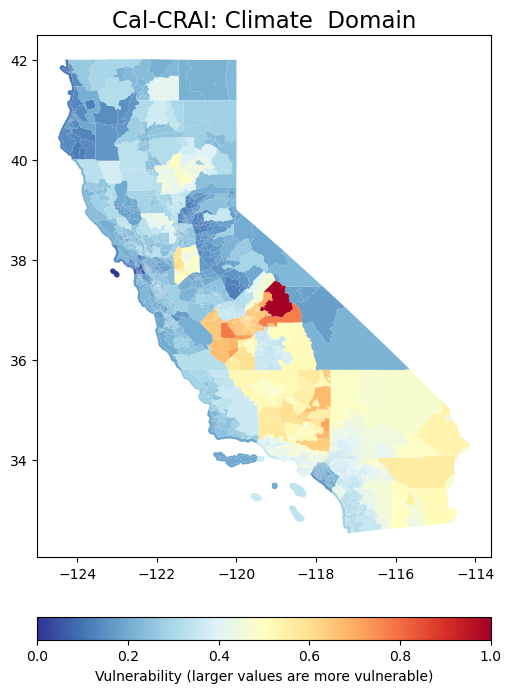

In [19]:
plot_domain(gdf, domain=domain_prefix)

### We can also visualize specific areas!
We call from a the `plot_region_domain` function which has a number of variables:

gdf : GeoDataFrame
    A GeoDataFrame containing the data you want to plot, which must include the column 'GEOID' to match with the census tract data.

counties_to_plot : list of str, optional
    A list of county FIPS codes (as strings) to plot. If None, no counties will be plotted.
    Example: ['037', '071', '065', '029', '111'].

region : str, optional
    A predefined region to plot. Options: 'bay_area', 'central_region', 'inland_deserts', 'north_central', 'northern', or 'south_coast'.
    If specified, this will override `counties_to_plot`.

plot_all : bool, optional
    If True, plots all counties in California. Overrides `counties_to_plot` and `region`.

savefig : bool, optional
    If True, the plot will be saved as a PNG file. Default is False.

font_color : str, optional
    Color of the font for county labels. Default is 'black'.

domain_name : str, optional
    Name of the domain to include in the plot title. Default is 'Society and Economy Domain'.


    Dictionary of county labels
    county_labels = {
        '001': 'Alameda', '003': 'Alpine', '005': 'Amador', '007': 'Butte', '009': 'Calaveras',
        '011': 'Colusa', '013': 'Contra Costa', '015': 'Del Norte', '017': 'El Dorado', '019': 'Fresno',
        '021': 'Glenn', '023': 'Humboldt', '025': 'Imperial', '027': 'Inyo', '029': 'Kern',
        '031': 'Kings', '033': 'Lake', '035': 'Lassen', '037': 'Los Angeles', '039': 'Madera',
        '041': 'Marin', '043': 'Mariposa', '045': 'Mendocino', '047': 'Merced', '049': 'Modoc',
        '051': 'Mono', '053': 'Monterey', '055': 'Napa', '057': 'Nevada', '059': 'Orange',
        '061': 'Placer', '063': 'Plumas', '065': 'Riverside', '067': 'Sacramento', '069': 'San Benito',
        '071': 'San Bernardino', '073': 'San Diego', '075': 'San Francisco', '077': 'San Joaquin',
        '079': 'San Luis Obispo', '081': 'San Mateo', '083': 'Santa Barbara', '085': 'Santa Clara',
        '087': 'Santa Cruz', '089': 'Shasta', '091': 'Sierra', '093': 'Siskiyou', '095': 'Solano',
        '097': 'Sonoma', '099': 'Stanislaus', '101': 'Sutter', '103': 'Tehama', '105': 'Trinity',
        '107': 'Tulare', '109': 'Tuolumne', '111': 'Ventura', '113': 'Yolo', '115': 'Yuba'

You can plot a domains vulnerability index by region, specific county/counties, or the entirety of CA with labels
Below are a few example of each of these plotting scenarios

Number of invalid geometries: 0


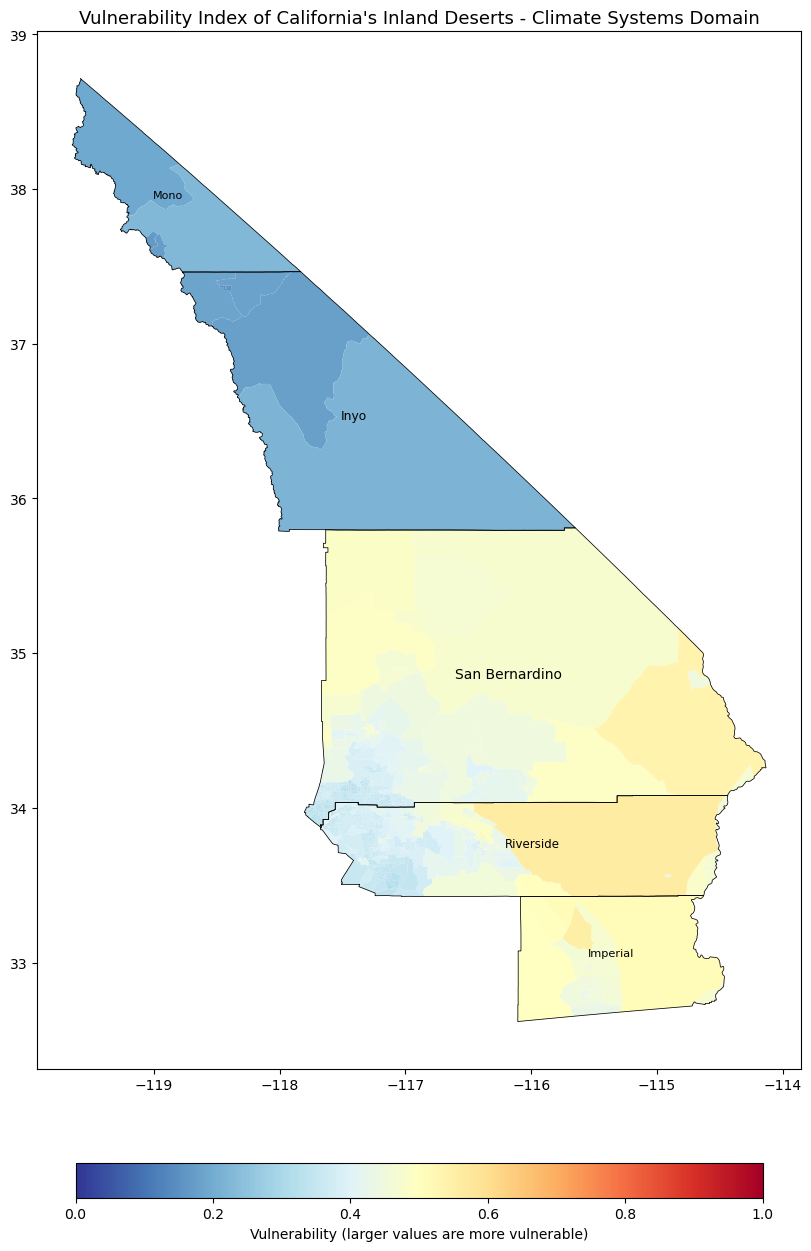

In [20]:
plot_region_domain(min_max_standardized_climate_systems_domain, domain=domain_prefix, domain_label_map={domain_prefix: 'Climate Systems Domain'}, region='inland_deserts', savefig=False, font_color='black')

Number of invalid geometries: 0


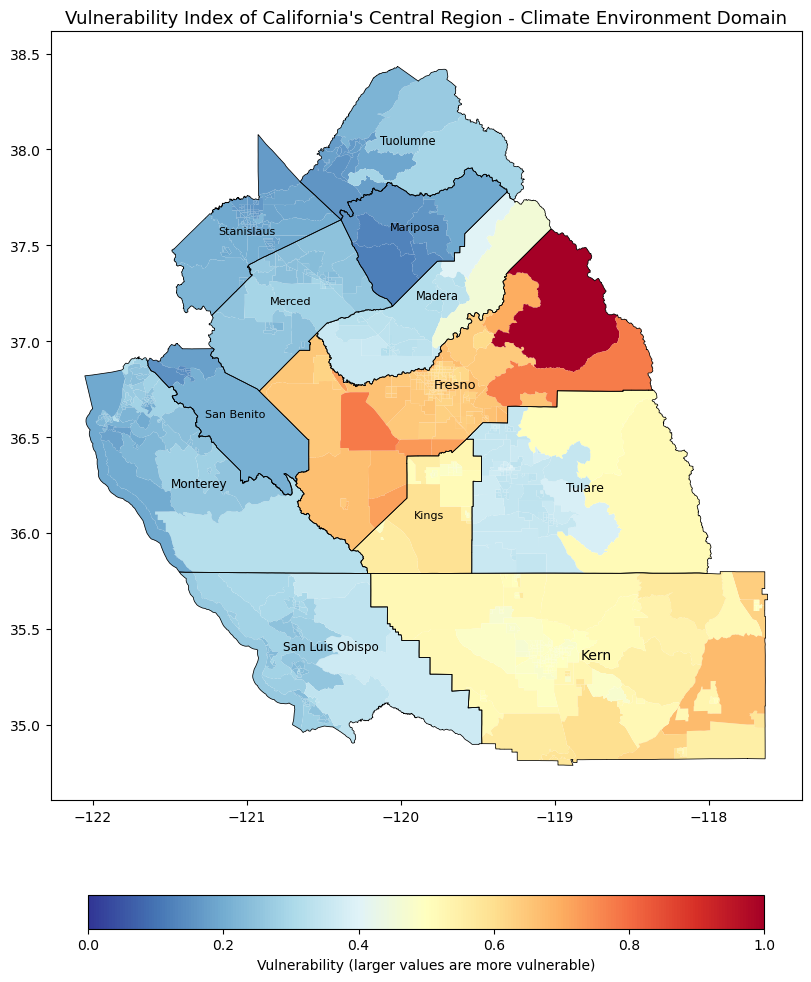

In [21]:
plot_region_domain(min_max_standardized_climate_systems_domain, domain=domain_prefix, domain_label_map={domain_prefix: 'Climate Environment Domain'}, region='central_region', savefig=False, font_color='black')

Number of invalid geometries: 0


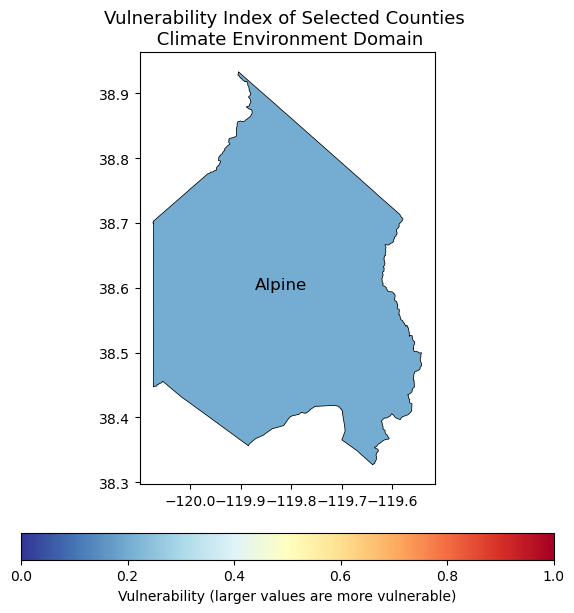

In [22]:
list_of_counties = ['003']
plot_region_domain(min_max_standardized_climate_systems_domain, domain=domain_prefix, domain_label_map={domain_prefix: 'Climate Environment Domain'}, counties_to_plot=list_of_counties, savefig=False, font_color='black')

Number of invalid geometries: 0


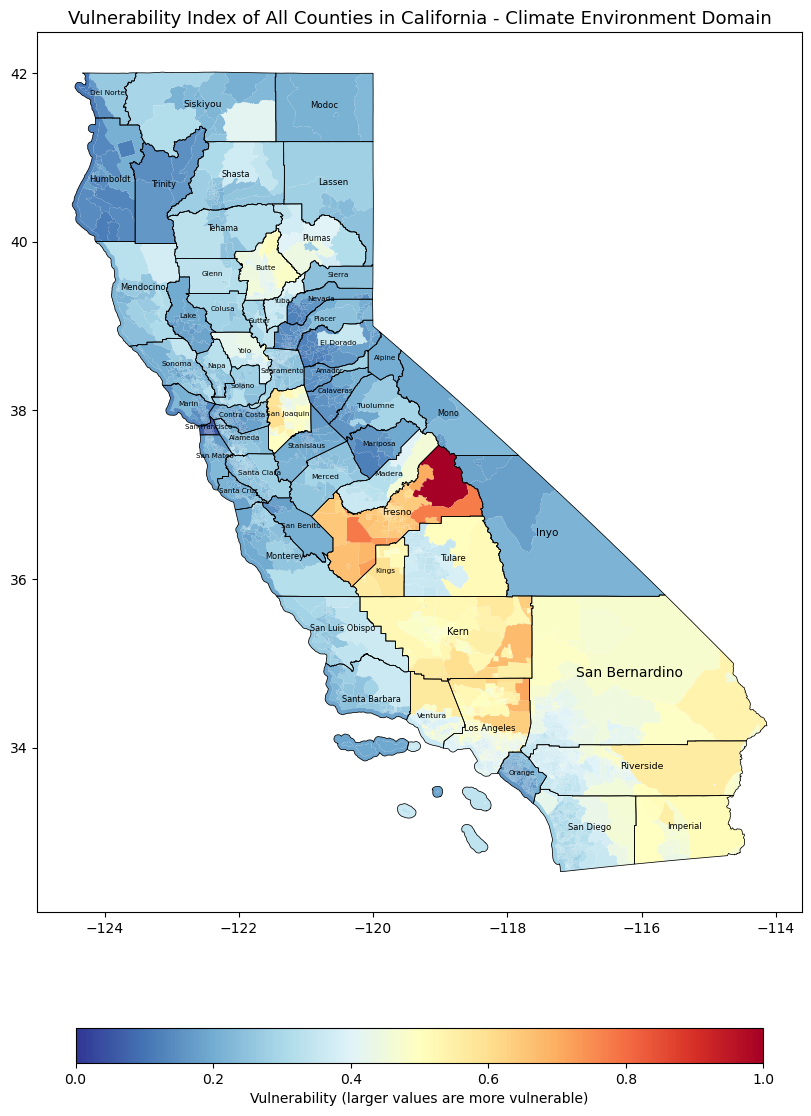

In [23]:
plot_region_domain(min_max_standardized_climate_systems_domain, domain=domain_prefix, domain_label_map={domain_prefix: 'Climate Environment Domain'}, plot_all=True, savefig=False, font_color='black')

## Step 4: Export the final domain csv file

In [28]:
# set-up file for export
domain_filename = '{}domain_index_calculation.csv'.format(domain_prefix)
gdf.to_csv(domain_filename, index=False)

In [29]:
# upload to aws bucket
bucket_name = 'ca-climate-index'
directory = '3_fair_data/index_data'

files_upload = indicator_filename, domain_filename

for file in files_upload:
    upload_csv_aws([file], bucket_name, directory)

climate_domain_averaged_indicators.csv uploaded to AWS
climate_domain_index_calculation.csv uploaded to AWS
